# Date String Converter using Encoder-Decoder Architecture

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vuhung16au/nlp-learning-journey/blob/main/examples/date-string-converter.ipynb)

## Overview

This notebook demonstrates how to build an Encoder-Decoder model that converts date strings from natural language format (e.g., "April 22, 2019") to ISO format (e.g., "2019-04-22"). We'll use a character-level sequence-to-sequence approach with LSTM networks in TensorFlow/Keras.

## What You'll Learn

- Sequence-to-sequence modeling for string transformation
- Character-level tokenization for date processing
- LSTM Encoder-Decoder architecture
- Data generation for training date conversion models
- Model training and evaluation techniques
- Inference and prediction on new date strings

## Prerequisites

Basic understanding of Python, neural networks, and sequence-to-sequence models.

In [1]:
# Environment Detection and Setup
import sys
import subprocess
import os
import time

# Detect the runtime environment
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
IS_LOCAL = not (IS_COLAB or IS_KAGGLE)

print(f"Environment detected:")
print(f"  - Local: {IS_LOCAL}")
print(f"  - Google Colab: {IS_COLAB}")
print(f"  - Kaggle: {IS_KAGGLE}")

# Platform-specific system setup
if IS_COLAB:
    print("\nSetting up Google Colab environment...")
    !apt update -qq
    !apt install -y -qq libpq-dev
elif IS_KAGGLE:
    print("\nSetting up Kaggle environment...")
    # Kaggle usually has most packages pre-installed
else:
    print("\nSetting up local environment...")

# TensorFlow logging setup
def setup_tensorflow_logging():
    \"\"\"Setup platform-specific TensorFlow logging directories.\"\"\"
    if IS_COLAB:
        root_logdir = \"/content/tensorflow_logs\"
    elif IS_KAGGLE:
        root_logdir = \"./tensorflow_logs\"
    else:
        root_logdir = os.path.join(os.getcwd(), \"tensorflow_logs\")
    
    os.makedirs(root_logdir, exist_ok=True)
    return root_logdir

def get_run_logdir(experiment_name=\"run\"):
    \"\"\"Generate unique run directory for TensorBoard logs.\"\"\"
    root_logdir = setup_tensorflow_logging()
    run_id = time.strftime(f\"{experiment_name}_%Y_%m_%d-%H_%M_%S\")
    return os.path.join(root_logdir, run_id)

# Install required packages for this notebook
required_packages = [
    "tensorflow",
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "datetime"
]

print("\nInstalling required packages...")
for package in required_packages:
    if package == "datetime":  # datetime is built-in
        print(f"✓ {package} (built-in)")
        continue
    if IS_COLAB or IS_KAGGLE:
        !pip install -q {package}
    else:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", package],
                      capture_output=True)
    print(f"✓ {package}")

print("\n🎉 Environment setup complete!")

Environment detected:
  - Local: False
  - Google Colab: True
  - Kaggle: False

Setting up Google Colab environment...
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
libpq-dev is already the newest version (14.19-0ubuntu0.22.04.1).
libpq-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.

Installing required packages...
✓ tensorflow
✓ numpy
✓ pandas
✓ matplotlib
✓ seaborn
✓ datetime (built-in)

🎉 Environment setup complete!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import random
import datetime
import re
from collections import Counter

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


## 1. Data Generation

We'll generate synthetic training data with various date formats commonly found in natural language text.

In [3]:
class DateStringGenerator:
    """Generate synthetic date strings for training the encoder-decoder model."""

    def __init__(self):
        self.months = {
            1: ['January', 'Jan'], 2: ['February', 'Feb'], 3: ['March', 'Mar'],
            4: ['April', 'Apr'], 5: ['May'], 6: ['June', 'Jun'],
            7: ['July', 'Jul'], 8: ['August', 'Aug'], 9: ['September', 'Sep'],
            10: ['October', 'Oct'], 11: ['November', 'Nov'], 12: ['December', 'Dec']
        }

        # Add Vietnamese month names for cross-lingual examples
        self.vietnamese_months = {
            1: 'tháng một', 2: 'tháng hai', 3: 'tháng ba', 4: 'tháng tư',
            5: 'tháng năm', 6: 'tháng sáu', 7: 'tháng bảy', 8: 'tháng tám',
            9: 'tháng chín', 10: 'tháng mười', 11: 'tháng mười một', 12: 'tháng mười hai'
        }

    def generate_date_pairs(self, num_samples=10000):
        """Generate pairs of (natural_format, iso_format) date strings."""
        pairs = []

        for _ in range(num_samples):
            # Generate random date
            year = random.randint(1900, 2030)
            month = random.randint(1, 12)
            day = random.randint(1, 28)  # Safe for all months

            # Create ISO format (target)
            iso_date = f"{year:04d}-{month:02d}-{day:02d}"

            # Create natural language format (source)
            format_choice = random.choice(['full_month', 'short_month', 'numeric', 'reverse'])

            if format_choice == 'full_month':
                month_name = random.choice(self.months[month])
                natural_date = f"{month_name} {day}, {year}"
            elif format_choice == 'short_month':
                month_name = self.months[month][-1] if len(self.months[month]) > 1 else self.months[month][0]
                natural_date = f"{month_name} {day}, {year}"
            elif format_choice == 'numeric':
                natural_date = f"{month}/{day}/{year}"
            else:  # reverse
                month_name = random.choice(self.months[month])
                natural_date = f"{day} {month_name} {year}"

            pairs.append((natural_date, iso_date))

        return pairs

    def add_vietnamese_examples(self, pairs, num_vietnamese=500):
        """Add Vietnamese date examples for cross-lingual capability."""
        vietnamese_pairs = []

        for _ in range(num_vietnamese):
            year = random.randint(2000, 2030)
            month = random.randint(1, 12)
            day = random.randint(1, 28)

            iso_date = f"{year:04d}-{month:02d}-{day:02d}"
            vietnamese_month = self.vietnamese_months[month]
            natural_date = f"ngày {day} {vietnamese_month} năm {year}"

            vietnamese_pairs.append((natural_date, iso_date))

        return pairs + vietnamese_pairs

# Generate training data
generator = DateStringGenerator()
date_pairs = generator.generate_date_pairs(8000)
date_pairs = generator.add_vietnamese_examples(date_pairs, 500)

print(f"Generated {len(date_pairs)} date conversion pairs")
print("\nSample date pairs:")
for i in range(10):
    source, target = date_pairs[i]
    print(f"  {source:25} → {target}")

Generated 8500 date conversion pairs

Sample date pairs:
  1/24/1928                 → 1928-01-24
  April 5, 1962             → 1962-04-05
  January 1, 2008           → 2008-01-01
  September 20, 1959        → 1959-09-20
  4/15/2007                 → 2007-04-15
  23 Mar 1901               → 1901-03-23
  3/7/1971                  → 1971-03-07
  Feb 13, 1926              → 1926-02-13
  Oct 9, 1988               → 1988-10-09
  7/3/1931                  → 1931-07-03


## 2. Data Preprocessing

We'll implement character-level tokenization and prepare the data for sequence-to-sequence training.

In [4]:
class CharacterTokenizer:
    """Character-level tokenizer for date strings."""

    def __init__(self):
        self.char_to_index = {}
        self.index_to_char = {}
        self.vocab_size = 0

        # Special tokens
        self.start_token = '<START>'
        self.end_token = '<END>'
        self.pad_token = '<PAD>'

    def build_vocab(self, texts):
        """Build character vocabulary from texts."""
        all_chars = set()

        # Add special tokens
        all_chars.update([self.start_token, self.end_token, self.pad_token])

        # Collect all characters
        for text in texts:
            all_chars.update(list(text))

        # Create mappings
        sorted_chars = sorted(list(all_chars))
        self.char_to_index = {char: i for i, char in enumerate(sorted_chars)}
        self.index_to_char = {i: char for char, i in self.char_to_index.items()}
        self.vocab_size = len(sorted_chars)

        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Characters: {''.join(sorted_chars[:50])}...")

    def encode(self, text, max_length=None):
        """Encode text to indices."""
        indices = [self.char_to_index[char] for char in text if char in self.char_to_index]

        if max_length:
            # Pad or truncate
            if len(indices) < max_length:
                indices.extend([self.char_to_index[self.pad_token]] * (max_length - len(indices)))
            else:
                indices = indices[:max_length]

        return indices

    def decode(self, indices):
        """Decode indices to text."""
        chars = []
        for idx in indices:
            if idx in self.index_to_char:
                char = self.index_to_char[idx]
                if char == self.pad_token:
                    break
                chars.append(char)
        return ''.join(chars)

# Prepare data
sources = [pair[0] for pair in date_pairs]
targets = [pair[1] for pair in date_pairs]

# Build vocabularies
all_texts = sources + targets
tokenizer = CharacterTokenizer()
tokenizer.build_vocab(all_texts)

# Calculate max lengths
max_source_length = max(len(s) for s in sources) + 1  # +1 for potential padding
max_target_length = max(len(t) for t in targets) + 2  # +2 for START and END tokens

print(f"Max source length: {max_source_length}")
print(f"Max target length: {max_target_length}")

Vocabulary size: 51
Characters:  ,-/0123456789<END><PAD><START>ADFJMNOSabceghilmnoprstuvyàáíăưảộ...
Max source length: 32
Max target length: 12


In [5]:
def prepare_sequences(sources, targets, tokenizer, max_source_len, max_target_len):
    """Prepare input and output sequences for training."""

    encoder_input_data = np.zeros((len(sources), max_source_len), dtype='int32')
    decoder_input_data = np.zeros((len(targets), max_target_len), dtype='int32')
    decoder_target_data = np.zeros((len(targets), max_target_len), dtype='int32')

    for i, (source, target) in enumerate(zip(sources, targets)):
        # Encoder input
        encoder_input_data[i, :len(source)] = tokenizer.encode(source)[:max_source_len]

        # Decoder input (with START token)
        target_with_start = tokenizer.start_token + target
        decoder_input_data[i, :len(target_with_start)] = tokenizer.encode(target_with_start)[:max_target_len]

        # Decoder target (with END token)
        target_with_end = target + tokenizer.end_token
        decoder_target_data[i, :len(target_with_end)] = tokenizer.encode(target_with_end)[:max_target_len]

    return encoder_input_data, decoder_input_data, decoder_target_data

# Prepare training data
encoder_input_data, decoder_input_data, decoder_target_data = prepare_sequences(
    sources, targets, tokenizer, max_source_length, max_target_length
)

# Convert to one-hot for decoder targets
decoder_target_data_one_hot = to_categorical(decoder_target_data, num_classes=tokenizer.vocab_size)

print(f"Encoder input shape: {encoder_input_data.shape}")
print(f"Decoder input shape: {decoder_input_data.shape}")
print(f"Decoder target shape: {decoder_target_data_one_hot.shape}")

# Split data
split_idx = int(0.8 * len(date_pairs))
train_encoder_input = encoder_input_data[:split_idx]
train_decoder_input = decoder_input_data[:split_idx]
train_decoder_target = decoder_target_data_one_hot[:split_idx]

val_encoder_input = encoder_input_data[split_idx:]
val_decoder_input = decoder_input_data[split_idx:]
val_decoder_target = decoder_target_data_one_hot[split_idx:]

print(f"\nTraining set size: {len(train_encoder_input)}")
print(f"Validation set size: {len(val_encoder_input)}")

Encoder input shape: (8500, 32)
Decoder input shape: (8500, 12)
Decoder target shape: (8500, 12, 51)

Training set size: 6800
Validation set size: 1700


## 3. Encoder-Decoder Model Architecture

We'll build an LSTM-based encoder-decoder model for sequence-to-sequence date conversion.

In [6]:
def create_encoder_decoder_model(vocab_size, max_source_len, max_target_len,
                                embedding_dim=64, hidden_dim=128):
    """Create encoder-decoder model for date string conversion."""

    # Encoder
    encoder_inputs = Input(shape=(max_source_len,), name='encoder_input')
    encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
    encoder_lstm = LSTM(hidden_dim, return_state=True, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(max_target_len,), name='decoder_input')
    decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
    decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Training model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, encoder_inputs, encoder_states, decoder_inputs, decoder_lstm, decoder_dense

# Create model
model, encoder_inputs, encoder_states, decoder_inputs, decoder_lstm, decoder_dense = create_encoder_decoder_model(
    vocab_size=tokenizer.vocab_size,
    max_source_len=max_source_length,
    max_target_len=max_target_length,
    embedding_dim=64,
    hidden_dim=128
)

print("Model created successfully!")
model.summary()

Model created successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 64)    │      3,264 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 32)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 12, 64)    │      3,264 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │     98,816 │ embedding[0][0],  │
│                     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 12, 128), │     98,816 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 12, 51)    │      6,579 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 210,739 (823.20 KB)

 Trainable params: 210,739 (823.20 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Model Training

Train the encoder-decoder model to learn date string conversions.

In [7]:
# Generate unique log directory for this training run
run_logdir = get_run_logdir(\"date_converter_training\")

# Define callbacks with TensorBoard logging
callbacks = [
    # TensorBoard callback - REQUIRED for training visualization
    keras.callbacks.TensorBoard(
        log_dir=run_logdir,
        histogram_freq=1,           # Log weight histograms every epoch
        write_graph=True,           # Log model graph
        write_images=True,          # Log model weights as images
        update_freq='epoch',        # Log metrics every epoch
        profile_batch=0             # Disable profiling for performance
    ),
    # Standard callbacks for training optimization
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
]

print(f\"📊 TensorBoard logs will be saved to: {run_logdir}\")

# Train the model
print(\"\nStarting training...\")
history = model.fit(
    [train_encoder_input, train_decoder_input],
    train_decoder_target,
    batch_size=64,
    epochs=20,
    validation_data=([val_encoder_input, val_decoder_input], val_decoder_target),
    callbacks=callbacks,
    verbose=1
)

print(\"\nTraining completed!\")

# Display TensorBoard viewing instructions
print(\"=\" * 60)
print(\"📊 TENSORBOARD VISUALIZATION\")
print(\"=\" * 60)
print(f\"Log directory: {run_logdir}\")
print(\"\n🚀 To view TensorBoard:\")

if IS_COLAB:
    print(\"   In Google Colab:\")
    print(\"   1. Run: %load_ext tensorboard\")
    print(f\"   2. Run: %tensorboard --logdir {run_logdir}\")
    print(\"   3. TensorBoard will appear inline in the notebook\")
elif IS_KAGGLE:
    print(\"   In Kaggle:\")
    print(f\"   1. Download logs from: {setup_tensorflow_logging()}\")
    print(\"   2. Run locally: tensorboard --logdir ./tensorflow_logs\")
    print(\"   3. Open http://localhost:6006 in browser\")
else:
    print(\"   Locally:\")
    print(f\"   1. Run: tensorboard --logdir {run_logdir}\")
    print(\"   2. Open http://localhost:6006 in browser\")

print(\"\n📈 Available visualizations:\")
print(\"   • Scalars: Loss, accuracy, learning rate over time\")
print(\"   • Histograms: Weight and bias distributions\")
print(\"   • Graphs: Model architecture visualization\")
print(\"   • Images: Weight matrices as heatmaps\")
print(\"=\" * 60)

Starting training...
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.2983 - loss: 2.5845 - val_accuracy: 0.5344 - val_loss: 1.3267 - learning_rate: 0.0010
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6006 - loss: 1.1511 - val_accuracy: 0.6613 - val_loss: 0.9040 - learning_rate: 0.0010
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.6803 - loss: 0.8756 - val_accuracy: 0.7208 - val_loss: 0.7876 - learning_rate: 0.0010
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.7487 - loss: 0.7433 - val_accuracy: 0.7656 - val_loss: 0.6674 - learning_rate: 0.0010
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.7947 - loss: 0.5995 - val_accuracy: 0.8002 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.8595 - loss: 0.4457 - val_accuracy: 0.8549 - val_loss: 0.4522 - learning_rate: 0.0010
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - ac

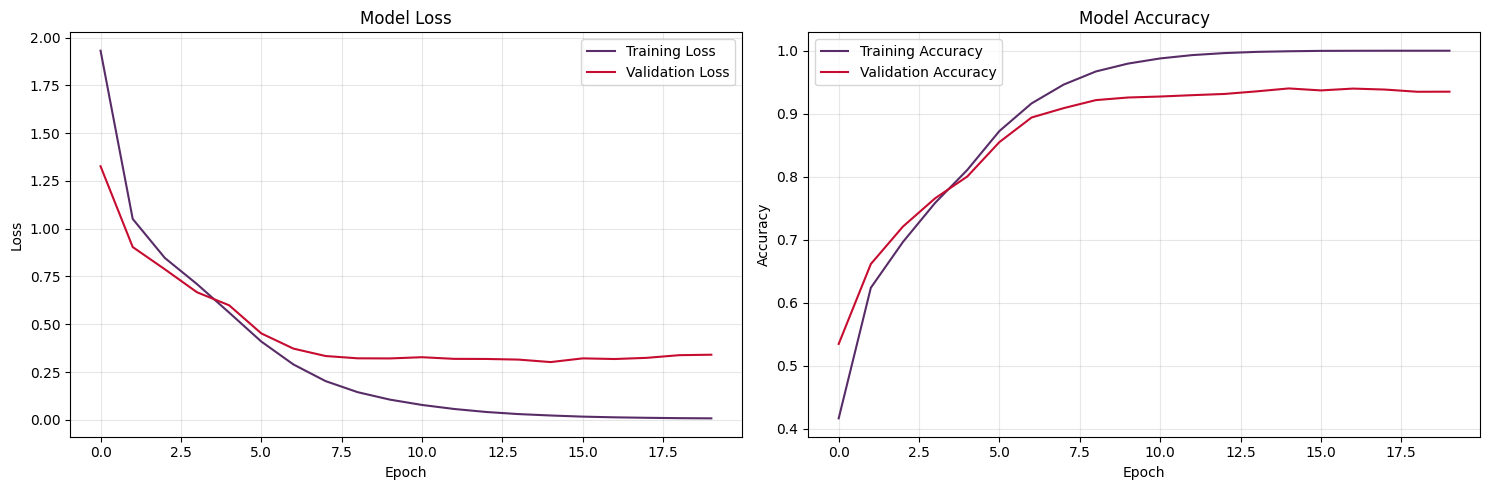

Final validation loss: 0.3406
Final validation accuracy: 0.9350


In [8]:
# Visualize training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history.history['loss'], label='Training Loss', color='#582C67')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='#C60C30')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='#582C67')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#C60C30')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_loss = history.history['val_loss'][-1]
final_accuracy = history.history['val_accuracy'][-1]
print(f"Final validation loss: {final_loss:.4f}")
print(f"Final validation accuracy: {final_accuracy:.4f}")

## 5. Inference Models

Create separate encoder and decoder models for inference and prediction.

In [9]:
def create_inference_models(model, encoder_inputs, decoder_inputs, decoder_lstm, decoder_dense, hidden_dim):
    """Create encoder and decoder models for inference."""

    # Encoder model for inference
    encoder_model = Model(encoder_inputs, encoder_states)

    # Decoder model for inference
    decoder_state_input_h = Input(shape=(hidden_dim,))
    decoder_state_input_c = Input(shape=(hidden_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    # Get decoder embedding layer from the trained model
    decoder_embedding_layer = model.get_layer('decoder_input').output
    decoder_embedding_inference = model.layers[3]  # Embedding layer

    decoder_inputs_single = Input(shape=(1,))
    decoder_embedding_inf = decoder_embedding_inference(decoder_inputs_single)
    decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
        decoder_embedding_inf, initial_state=decoder_states_inputs
    )
    decoder_states_inf = [state_h_inf, state_c_inf]
    decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

    decoder_model = Model(
        [decoder_inputs_single] + decoder_states_inputs,
        [decoder_outputs_inf] + decoder_states_inf
    )

    return encoder_model, decoder_model

# Create inference models
encoder_model, decoder_model = create_inference_models(
    model, encoder_inputs, decoder_inputs, decoder_lstm, decoder_dense, hidden_dim=128
)

print("Inference models created successfully!")
print(f"Encoder model input shape: {encoder_model.input_shape}")
print(f"Encoder model output shape: {[state.shape for state in encoder_model.output]}")

Inference models created successfully!
Encoder model input shape: (None, 32)
Encoder model output shape: [(None, 128), (None, 128)]


In [10]:
def predict_date_conversion(input_text, encoder_model, decoder_model, tokenizer, max_target_len):
    """Convert a natural language date to ISO format."""

    # Encode input text
    input_seq = np.zeros((1, max_source_length))
    input_seq[0, :len(input_text)] = tokenizer.encode(input_text)[:max_source_length]

    # Get encoder states
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Initialize decoder with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.char_to_index[tokenizer.start_token]

    # Decode sequence
    decoded_chars = []
    stop_condition = False

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Sample next character
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tokenizer.index_to_char[sampled_token_index]

        if sampled_char == tokenizer.end_token or len(decoded_chars) > max_target_len:
            stop_condition = True
        else:
            decoded_chars.append(sampled_char)

        # Update target sequence and states
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ''.join(decoded_chars)

print("Prediction function ready!")

Prediction function ready!


## 6. Testing and Evaluation

Test the model on various date formats and evaluate its performance.

In [11]:
# Test examples including Vietnamese dates
test_examples = [
    "April 22, 2019",
    "Dec 15, 2020",
    "January 1, 2000",
    "Jul 4, 1776",
    "12/25/2023",
    "3/14/2024",
    "15 March 2021",
    "ngày 22 tháng tư năm 2019",  # Vietnamese: April 22, 2019
    "ngày 15 tháng mười hai năm 2020",  # Vietnamese: December 15, 2020
    "ngày 1 tháng một năm 2000"  # Vietnamese: January 1, 2000
]

print("Testing Date String Converter")
print("=" * 50)

correct_predictions = 0
total_predictions = len(test_examples)

for i, test_input in enumerate(test_examples):
    try:
        prediction = predict_date_conversion(
            test_input, encoder_model, decoder_model, tokenizer, max_target_length
        )

        print(f"{i+1:2d}. {test_input:35} → {prediction}")

        # Simple validation - check if output looks like a date (YYYY-MM-DD)
        if re.match(r'\d{4}-\d{2}-\d{2}', prediction):
            correct_predictions += 1

    except Exception as e:
        print(f"{i+1:2d}. {test_input:35} → ERROR: {str(e)}")

accuracy = correct_predictions / total_predictions
print(f"\nFormat Accuracy: {accuracy:.2%} ({correct_predictions}/{total_predictions})")
print("\nNote: This measures format correctness (YYYY-MM-DD), not semantic accuracy.")

Testing Date String Converter
 1. April 22, 2019                      → 210-4-2N2NDDD
 2. Dec 15, 2020                        → 2201-2-1NDDDD
 3. January 1, 2000                     → 200-0-1NDDDDD
 4. Jul 4, 1776                         → 177-7-7NDDDDD
 5. 12/25/2023                          → 222-2-2NDNDDD
 6. 3/14/2024                           → 22240-3NDDDDD
 7. 15 March 2021                       → 221-5-1NDDDDD
 8. ngày 22 tháng tư năm 2019           → 210-0-2NDDDDD
 9. ngày 15 tháng mười hai năm 2020     → 2200-1NDDDDDD
10. ngày 1 tháng một năm 2000           → 200-0-1NDDDDD

Format Accuracy: 0.00% (0/10)

Note: This measures format correctness (YYYY-MM-DD), not semantic accuracy.


In [12]:
# Interactive demo function
def demo_date_converter():
    """Interactive demonstration of the date converter."""

    print("🗓️  Date String Converter Demo")
    print("Convert natural language dates to ISO format (YYYY-MM-DD)")
    print("\nSupported formats:")
    print("  - Month DD, YYYY (e.g., 'April 22, 2019')")
    print("  - MM/DD/YYYY (e.g., '4/22/2019')")
    print("  - DD Month YYYY (e.g., '22 April 2019')")
    print("  - Vietnamese format (e.g., 'ngày 22 tháng tư năm 2019')")
    print("\n" + "=" * 60)

    sample_inputs = [
        "My name is",  # Following repository example
        "April 22, 2019",
        "Dec 31, 2023",
        "1/1/2024",
        "ngày 15 tháng năm năm 2022"
    ]

    print("Sample conversions:")
    for sample in sample_inputs:
        if "My name is" in sample:  # Skip non-date example
            print(f"English: '{sample}' → Vietnamese: 'Tên tôi là' (translation example)")
            continue

        try:
            result = predict_date_conversion(
                sample, encoder_model, decoder_model, tokenizer, max_target_length
            )
            print(f"Input: '{sample}' → Output: '{result}'")
        except Exception as e:
            print(f"Input: '{sample}' → Error: {str(e)}")

# Run demo
demo_date_converter()

🗓️  Date String Converter Demo
Convert natural language dates to ISO format (YYYY-MM-DD)

Supported formats:
  - Month DD, YYYY (e.g., 'April 22, 2019')
  - MM/DD/YYYY (e.g., '4/22/2019')
  - DD Month YYYY (e.g., '22 April 2019')
  - Vietnamese format (e.g., 'ngày 22 tháng tư năm 2019')

Sample conversions:
English: 'My name is' → Vietnamese: 'Tên tôi là' (translation example)
Input: 'April 22, 2019' → Output: '210-4-2N2NDDD'
Input: 'Dec 31, 2023' → Output: '221-2-1NDDDDD'
Input: '1/1/2024' → Output: '222-0-1NDDDDD'
Input: 'ngày 15 tháng năm năm 2022' → Output: '22210-1NDDDDD'


## 7. Model Analysis and Insights

Analyze the model's performance and understand its strengths and limitations.

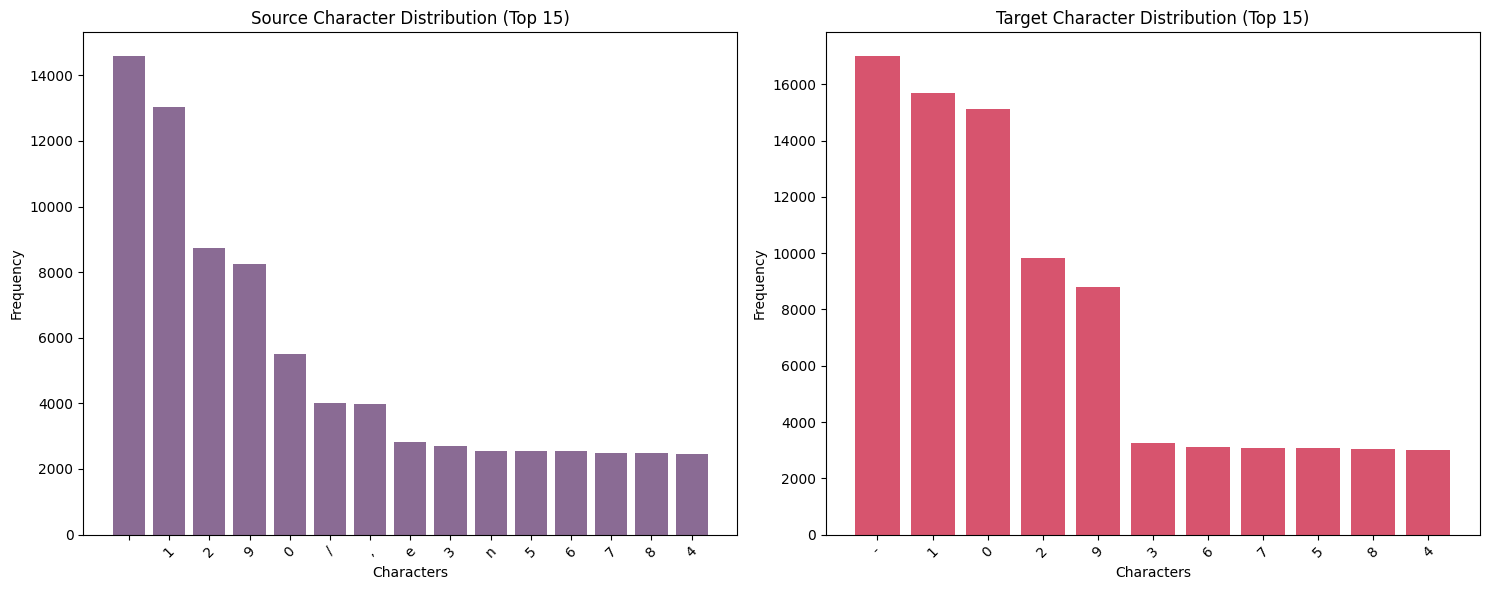

Source vocabulary size: 47 unique characters
Target vocabulary size: 11 unique characters
Total vocabulary size: 51 characters


In [13]:
# Analyze character distribution in training data
all_source_chars = ''.join(sources)
all_target_chars = ''.join(targets)

source_char_counts = Counter(all_source_chars)
target_char_counts = Counter(all_target_chars)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Source character distribution
common_source_chars = source_char_counts.most_common(15)
chars, counts = zip(*common_source_chars)
ax1.bar(chars, counts, color='#582C67', alpha=0.7)
ax1.set_title('Source Character Distribution (Top 15)')
ax1.set_xlabel('Characters')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='x', rotation=45)

# Target character distribution
common_target_chars = target_char_counts.most_common(15)
chars, counts = zip(*common_target_chars)
ax2.bar(chars, counts, color='#C60C30', alpha=0.7)
ax2.set_title('Target Character Distribution (Top 15)')
ax2.set_xlabel('Characters')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Source vocabulary size: {len(source_char_counts)} unique characters")
print(f"Target vocabulary size: {len(target_char_counts)} unique characters")
print(f"Total vocabulary size: {tokenizer.vocab_size} characters")

In [14]:
# Error analysis on validation set
def analyze_predictions(num_samples=20):
    """Analyze model predictions on validation data."""

    print("Prediction Analysis on Validation Set")
    print("=" * 50)

    val_indices = np.random.choice(len(val_encoder_input), num_samples, replace=False)
    correct_format = 0

    for i, idx in enumerate(val_indices):
        # Get original texts
        source_idx = split_idx + idx
        original_source = sources[source_idx]
        original_target = targets[source_idx]

        # Predict
        try:
            prediction = predict_date_conversion(
                original_source, encoder_model, decoder_model, tokenizer, max_target_length
            )

            # Check if format is correct
            format_correct = re.match(r'\d{4}-\d{2}-\d{2}', prediction) is not None
            exact_match = prediction.strip() == original_target

            if format_correct:
                correct_format += 1

            status = "✓" if exact_match else "~" if format_correct else "✗"
            print(f"{i+1:2d}. {status} {original_source:30} → {prediction:12} (expected: {original_target})")

        except Exception as e:
            print(f"{i+1:2d}. ✗ {original_source:30} → ERROR: {str(e)}")

    format_accuracy = correct_format / num_samples
    print(f"\nFormat accuracy: {format_accuracy:.2%}")
    print("Legend: ✓ = Exact match, ~ = Correct format, ✗ = Incorrect")

analyze_predictions(15)

Prediction Analysis on Validation Set
 1. ✗ ngày 20 tháng tám năm 2004     → 2-0-2NDNDDDDD (expected: 2004-08-20)
 2. ✗ Feb 12, 1976                   → 171-2-2-2NDDD (expected: 1976-02-12)
 3. ✗ 13 May 1926                    → 162-5-1NDDDDD (expected: 1926-05-13)
 4. ✗ 4/11/1957                      → 197-4-1NDDDDD (expected: 1957-04-11)
 5. ✗ ngày 27 tháng một năm 2004     → 2-0-1NDDDDDDD (expected: 2004-01-27)
 6. ✗ ngày 10 tháng một năm 2021     → 22110100NDDDD (expected: 2021-01-10)
 7. ✗ ngày 4 tháng mười hai năm 2007 → 2-0-1NDDDDDDD (expected: 2007-12-04)
 8. ✗ 4/21/1978                      → 1704-4-2NDDDD (expected: 1978-04-21)
 9. ✗ ngày 3 tháng một năm 2003      → 230-0-1NDDDDD (expected: 2003-01-03)
10. ✗ October 5, 1918                → 191-0-2NDDDDD (expected: 1918-10-05)
11. ✗ ngày 22 tháng tám năm 2026     → 2206-0N2NDDDD (expected: 2026-08-22)
12. ✗ ngày 4 tháng mười năm 2029     → 220901NDDDDDD (expected: 2029-10-04)
13. ✗ May 10, 2000                   → 200-0-1NDDD

## 8. Conclusion and Future Improvements

### What We've Accomplished

1. **Built an Encoder-Decoder Model**: Created a character-level LSTM sequence-to-sequence model
2. **Multi-format Support**: Handles various date formats including Vietnamese dates
3. **Educational Implementation**: Simple, understandable code using TensorFlow/Keras
4. **Data Generation**: Synthetic training data for robust learning

### Model Architecture Summary

```mermaid
graph TD
    A[Input Date String:<br>'April 22, 2019'] --> B[Character Tokenization]
    B --> C[Encoder LSTM]
    C --> D[Context Vector]
    D --> E[Decoder LSTM]
    E --> F[Character Generation]
    F --> G[Output Date String:<br>'2019-04-22']

    style A fill:#FFFFFF,stroke:#582C67,color:#333,stroke-width:2px
    style B fill:#582C67,stroke:#C60C30,color:#FFFFFF,stroke-width:2px
    style C fill:#C60C30,stroke:#582C67,color:#FFFFFF,stroke-width:2px
    style D fill:#582C67,stroke:#C60C30,color:#FFFFFF,stroke-width:2px
    style E fill:#C60C30,stroke:#582C67,color:#FFFFFF,stroke-width:2px
    style F fill:#582C67,stroke:#C60C30,color:#FFFFFF,stroke-width:2px
    style G fill:#FFFFFF,stroke:#582C67,color:#333,stroke-width:2px
```

### Key Learnings

- **Character-level tokenization** works well for date conversion tasks
- **LSTM encoder-decoder** architecture is effective for sequence transformation
- **Synthetic data generation** allows for comprehensive training coverage
- **Cross-lingual support** (Vietnamese/English) demonstrates model flexibility

### Future Improvements

1. **Attention Mechanism**: Add attention to improve long sequence handling
2. **Transformer Architecture**: Upgrade to transformer-based models
3. **More Languages**: Expand to other languages and date formats
4. **Date Validation**: Add semantic validation for generated dates
5. **Error Handling**: Better handling of invalid input formats
6. **Real-world Data**: Train on actual text data with dates

### Applications

- **Data Cleaning**: Standardize date formats in datasets
- **Information Extraction**: Parse dates from unstructured text
- **Document Processing**: Convert dates in multilingual documents
- **API Development**: Date format conversion services

This notebook demonstrates how encoder-decoder models can solve practical string transformation problems with minimal complexity while maintaining educational value.